# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
import gzip

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

## Exploración de Datos

### Dataset Reviews

In [2]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

In [4]:
data_reviews = pd.DataFrame(data_reviews)

NameError: name 'data_reviews' is not defined

In [5]:
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,NaN


In [50]:
data_reviews.to_csv('reviews_n10.csv', index= False) #Exporto el dataset a un .csv para tener un dataset preprocesado y no tener que repetir código que tarde en correr.

NameError: name 'data_reviews' is not defined

#### Comienzo a trabajar con el dataset "preprocesado"

In [21]:
df = pd.read_csv('reviews_n10.csv')
print(df.shape)
df.head()

(779307, 12)


,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,7.656120e+16,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,7.656120e+16,NaN,NaN


##### ¿Los usuarios que  mayor cantidad de juegos poseen son aquellos que mayor tiempo de juego tienen en las review? 

In [31]:
df.products.quantile(0.90)

507.0

Tomaremos como usuarios con gran cantidad de juegos aquellos usuarios que tienen por encima de 507 juegos (10% de la muestra):

In [35]:
usu_cantj=df[df.products>507]

In [33]:
usu_cantj.hours.describe()

count    77036.000000
mean        49.914401
std        306.218951
min          0.000000
25%          2.500000
50%          7.500000
75%         23.600000
max      20018.900000
Name: hours, dtype: float64

El promedio de tiempo de juego es de 50 hs. 

Buscaremos ahora cual es el tiempo de juego para aquellos usuarios que no posean tanta cantidad de juegos:

In [50]:
usu_cantj=df[df.products<18]

In [51]:
usu_cantj.hours.describe()

count    76677.000000
mean       186.898950
std        510.520698
min          0.000000
25%          4.400000
50%         23.500000
75%        123.500000
max      19205.200000
Name: hours, dtype: float64

Tomando como referencia una cantidad de registros similares para el análisis, podemos ver que aquellos que no tienen tanta cantidad de juegos tienen un mayor tiempo de juego al momento de efectuar la review. Podemos concluir que tener una alta cantidad de juegos no aumenta el tiempo de juego para la review (de hecho se observa lo contrario).

In [79]:
df=df.drop(columns=['text','page','page_order','user_id']) #elimino las columnas que no voy a utilizar
df.head()

,username,hours,products,product_id,date,early_access,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,2017-12-17,False,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2017-08-02,False,NaN,NaN
2,freakfantom,0.1,1706.0,725280,2017-11-12,False,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,2017-12-11,False,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,2018-01-02,False,NaN,NaN


In [80]:
print(f'Cantidad de filas:{df.shape[0]}. Cantidad de columnas:{df.shape[1]}') #cantidad de filas y columnas

Cantidad de filas:779307. Cantidad de columnas:8


#### Imputación de valores faltantes y Encoding

In [54]:
df.corr()

,hours,products,product_id,early_access,found_funny
hours,1.000000,-0.053949,-0.115089,0.031137,0.029418
products,-0.053949,1.000000,0.024158,-0.062165,0.005850
product_id,-0.115089,0.024158,1.000000,0.228317,-0.011196
early_access,0.031137,-0.062165,0.228317,1.000000,0.003403
found_funny,0.029418,0.005850,-0.011196,0.003403,1.000000


Debido a la baja correlación entre las variables podemos descartar algún pérdida de valores nulos por MNAR (Missing not At Random)

In [55]:
df.isna().sum()

username            18
hours             2637
products          1566
product_id           0
date                 0
early_access         0
compensation    764719
found_funny     659143
dtype: int64

In [56]:
print(round((df.isna().sum()* 100/ len(df)),2).sort_values(ascending=False)) #valores faltantes por columna en %

compensation    98.13
found_funny     84.58
hours            0.34
products         0.20
username         0.00
product_id       0.00
date             0.00
early_access     0.00
dtype: float64


Analizaremos a continuación cada una de las columnas que incluyen valores nulos, de forma tal de tratarlas de acuerdo a su origen:

In [81]:
df['compensation'].unique()

array([nan, 'Product received for free'], dtype=object)

La columna "compensation" incluye solo dos valores (nulo cuando el juego no fue recibido de forma gratuita y sino especificado con el texto 'Product received for free'), por tanto podemos convertirla a una columna booleana con valores 0 y 1

In [82]:
df['compensation']=df['compensation'].map({'Product received for free':'1'})
df['compensation'] = df['compensation'].fillna(0)
df.head()

,username,hours,products,product_id,date,early_access,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,2017-12-17,False,0,NaN
1,Ariman1,13.2,1386.0,328100,2017-08-02,False,0,NaN
2,freakfantom,0.1,1706.0,725280,2017-11-12,False,0,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,2017-12-11,False,1,NaN
4,the_maker988,8.2,18.0,35140,2018-01-02,False,0,NaN


In [83]:
df[df.found_funny.notnull()]

,username,hours,products,product_id,date,early_access,compensation,found_funny
5,Szudof,0.2,155.0,288690,2016-08-31,False,1,3.0
7,LucaFox,4.0,136.0,620900,2017-09-11,False,0,1.0
9,Devil Azite,0.1,548.0,671270,2017-07-09,False,1,1.0
14,tehwave,0.1,424.0,671270,2017-07-05,False,1,3.0
15,Hanzo,0.2,531.0,8880,2017-09-09,False,0,3.0
...,...,...,...,...,...,...,...,...
779256,Noodle,96.6,175.0,252490,2013-12-14,True,0,1.0
779257,SGC | Atome,111.7,52.0,252490,2013-12-13,True,0,1.0
779258,beren,254.6,198.0,252490,2013-12-14,True,0,1.0
779278,KappaJ,248.9,128.0,252490,2013-12-12,True,0,2.0


La columna 'found funny' incluye los valores nulos cuando nadie considero divertida la review, es por eso que podemos reemplazar sus valores por 0 (marcaría la cantidad de usuarios que la consideraron divertida)

In [84]:
df['found_funny'] = df['found_funny'].fillna(0)
df.head()

,username,hours,products,product_id,date,early_access,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,2017-12-17,False,0,0.0
1,Ariman1,13.2,1386.0,328100,2017-08-02,False,0,0.0
2,freakfantom,0.1,1706.0,725280,2017-11-12,False,0,0.0
3,The_Cpt_FROGGY,7.8,2217.0,631920,2017-12-11,False,1,0.0
4,the_maker988,8.2,18.0,35140,2018-01-02,False,0,0.0


In [85]:
#Completo el valor faltante de 'horas' utilizando el valor promedio de horas para el juego específico de esa review
df['hours'] = df['hours'].groupby(df['product_id']).apply(lambda x: x.fillna(np.mean(x)))
#Completo el valor faltantes de 'productos' utilizando el valor promedio ya que la cantidad de registros nulos para esta columna no es significativa
df['products'] = df['products'].fillna(df.products.mean())

In [86]:
df.isna().sum()

username          18
hours           1035
products           0
product_id         0
date               0
early_access       0
compensation       0
found_funny        0
dtype: int64

Los valores faltantes de horas se deben a cantidad de horas en las reviews no tienen horas de juego

In [87]:
#Reemplazo esos valores nulos por 0
df['hours'] = df['hours'].fillna(0)
df.head()

,username,hours,products,product_id,date,early_access,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,2017-12-17,False,0,0.0
1,Ariman1,13.2,1386.0,328100,2017-08-02,False,0,0.0
2,freakfantom,0.1,1706.0,725280,2017-11-12,False,0,0.0
3,The_Cpt_FROGGY,7.8,2217.0,631920,2017-12-11,False,1,0.0
4,the_maker988,8.2,18.0,35140,2018-01-02,False,0,0.0


Elimino los valores nulos de en la columna de "usuarios" ya que son solamente 18 registros

In [88]:
df = df.dropna(axis=0, subset=['username'])

In [89]:
df.isna().sum()

username        0
hours           0
products        0
product_id      0
date            0
early_access    0
compensation    0
found_funny     0
dtype: int64

In [90]:
print(f'Cantidad de filas:{df.shape[0]}. Cantidad de columnas:{df.shape[1]}') #cantidad de filas y columnas

Cantidad de filas:779289. Cantidad de columnas:8


#### Detección y eliminación de Outliers

In [131]:
df.describe()

,hours,products,product_id,found_funny
count,779289.000000,779289.000000,779289.000000,779289.000000
mean,111.506173,236.994077,251490.727079,1.189325
std,389.420058,485.549695,149976.171467,28.591729
min,0.000000,1.000000,10.000000,0.000000
25%,4.000000,46.000000,203770.000000,0.000000
50%,15.200000,111.000000,252490.000000,0.000000
75%,59.400000,246.000000,346110.000000,0.000000
max,28164.000000,13540.000000,773900.000000,6524.000000


<AxesSubplot:xlabel='hours'>

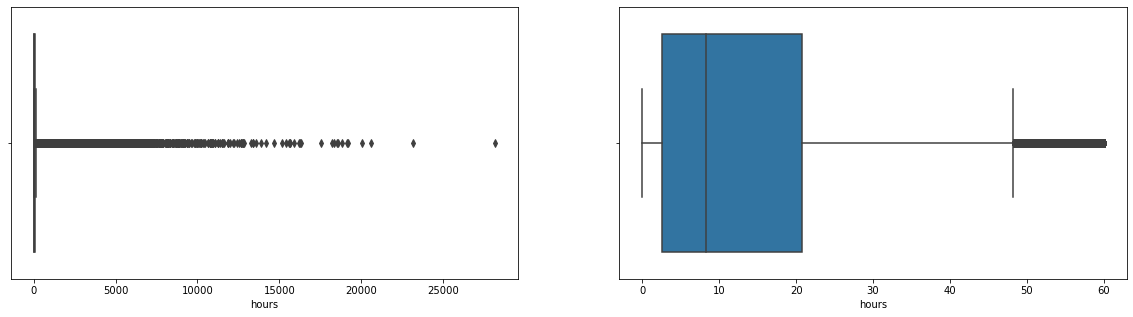

In [158]:
#Estudio de variable 'hours'

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.boxplot(data=df,x='hours') #Detecto rápidamente los outliers con el gráfico

plt.subplot(1,2,2)
filtro_horas=df[df.hours<=60] #Utilizando este valor logro centralizar el rango de datos, tomando una muestra abarcativa de la población
sns.boxplot(data=filtro_horas,x='hours') 

Tomo el valor 60, debido a que con ese valor logro representar un 75% de la población. Esto se puede apreciar mediante el comando "describe" y se valida gráficamente

<AxesSubplot:xlabel='products'>

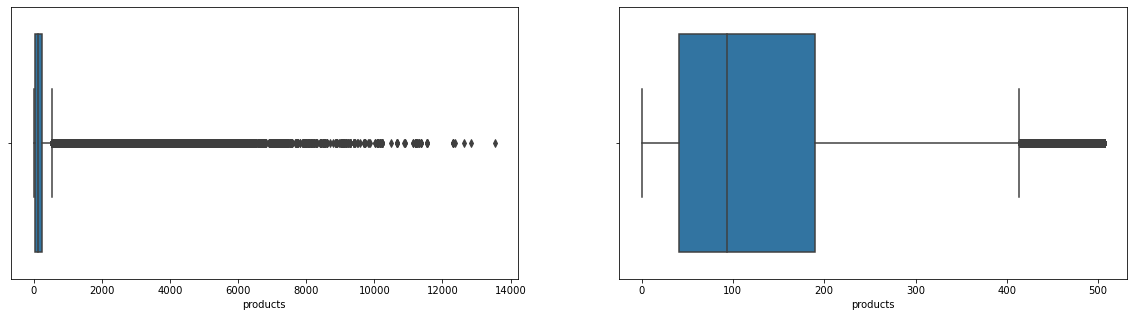

In [165]:
#Estudio de variable 'products'

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.boxplot(data=df,x='products') #Detecto rápidamente los outliers con el gráfico

plt.subplot(1,2,2)
filtro_productos=df[df.products<=506] #Utilizando este valor logro centralizar el rango de datos, tomando una muestra abarcativa de la población
sns.boxplot(data=filtro_productos,x='products') 

In [164]:
df.products.quantile(0.90)

506.0

Tomo el valor 506, debido a que con ese valor logro representar un 90% de la población. Esto se puede apreciar mediante el comando "quantile" y se valida gráficamente

In [91]:
df=df[((df.hours<60) & (df.products>506))]

#### Ranking basado en horas jugadas

Como primer paso para determinar los intervalos para "rankear" la cantidad de horas jugadas en cada review, es conveniente analizar la distribución de la variable "horas" para generar intervalos lo más uniformes posibles

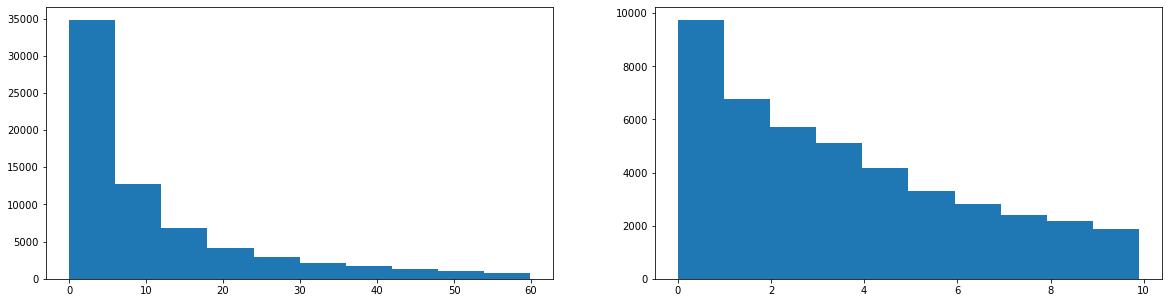

In [235]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(df['hours']) #Gráfico de distribución de horas jugadas

filtro=df[df.hours<10] #Utilizando este valor logro centralizar el rango de datos, tomando una muestra abarcativa de la población
plt.subplot(1,2,2)
plt.hist(filtro['hours'])
plt.show()

In [92]:
df['ranking']=pd.cut(df.hours,[-1,3.05,10.8,61], labels=[1,2,3],right=False)
df.head()

,username,hours,products,product_id,date,early_access,compensation,found_funny,ranking
1,Ariman1,13.2,1386.0,328100,2017-08-02,False,0,0.0,3
2,freakfantom,0.1,1706.0,725280,2017-11-12,False,0,0.0,1
3,The_Cpt_FROGGY,7.8,2217.0,631920,2017-12-11,False,1,0.0,2
9,Devil Azite,0.1,548.0,671270,2017-07-09,False,1,1.0,1
10,MrNinjaSquirrel,1.2,1720.0,288690,2014-12-17,False,0,0.0,1


[Text(0.5, 0, 'Cantidad Reviews'), Text(0, 0.5, 'Ranking (Hs Jugadas)')]

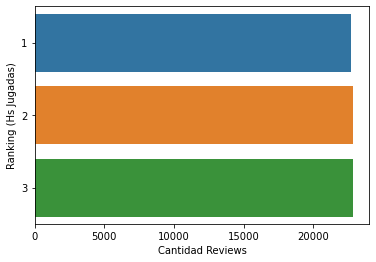

In [94]:
sns.countplot(data=df,y="ranking").set(xlabel='Cantidad Reviews', ylabel='Ranking (Hs Jugadas)') #Gráfico en Seaborn

In [95]:
df['ranking'].value_counts() #cantidad de instancias según ranking

3    22884
2    22846
1    22728
Name: ranking, dtype: int64

En base a los valores y los intervalos definidos podemos clasificar cada review según nivel de horas jugadas en 3 tipos de valores crecientes en cantidad de horas jugadas (1,2,3). Como se puede observar mediante el gráfico y el value_counts, la distribución del ranking es uniforme dentro de los 3 valores definidos

#### Armado de Diccionario de Usuarios

In [96]:
usuarios=df['username'].unique() #me quedo con un único valor por usuario
df_usuarios= pd.DataFrame(usuarios,columns=['username'])
df_usuarios.head()

,username
0,Ariman1
1,freakfantom
2,The_Cpt_FROGGY
3,Devil Azite
4,MrNinjaSquirrel


In [97]:
df_usuarios['username_id'] = range(0,len(df_usuarios)) #le defino un id a cada uno de los usuarios
df_usuarios.set_index('username')
df_usuarios.head()

,username,username_id
0,Ariman1,0
1,freakfantom,1
2,The_Cpt_FROGGY,2
3,Devil Azite,3
4,MrNinjaSquirrel,4


In [98]:
print(f'Cantidad de filas:{df_usuarios.shape[0]}. Cantidad de columnas:{df_usuarios.shape[1]}') #cantidad de filas y columnas

Cantidad de filas:32212. Cantidad de columnas:2


In [99]:
df_usuarios.to_csv('usuarios.csv') #Exporto el dataset a un .csv para tener un dataset preprocesado y no tener que repetir código que tarde en correr.

In [100]:
df=df.join(df_usuarios.set_index('username'), on='username') #unifico cada una de las reviews con el respectivo id del usuario
df

,username,hours,products,product_id,date,early_access,compensation,found_funny,ranking,username_id
1,Ariman1,13.2,1386.0,328100,2017-08-02,False,0,0.0,3,0
2,freakfantom,0.1,1706.0,725280,2017-11-12,False,0,0.0,1,1
3,The_Cpt_FROGGY,7.8,2217.0,631920,2017-12-11,False,1,0.0,2,2
9,Devil Azite,0.1,548.0,671270,2017-07-09,False,1,1.0,1,3
10,MrNinjaSquirrel,1.2,1720.0,288690,2014-12-17,False,0,0.0,1,4
...,...,...,...,...,...,...,...,...,...,...
779040,Anosh,21.0,509.0,252490,2013-12-30,True,0,0.0,3,32210
779160,Skunk,40.1,1229.0,252490,2013-12-22,True,0,0.0,3,20477
779167,BiCE,32.2,678.0,252490,2013-12-21,True,0,0.0,3,32211
779172,jungle.james,30.6,1504.0,252490,2013-12-21,True,0,0.0,3,10372


In [101]:
print(f'Cantidad de filas:{df.shape[0]}. Cantidad de columnas:{df.shape[1]}') #cantidad de filas y columnas

Cantidad de filas:68458. Cantidad de columnas:10


#### Tabla base del Sistema de Recomendación

In [102]:
df_base= df.drop(columns=['username','hours','products','date','early_access','compensation','found_funny'])
df_base #me quedo con la tabla base para poder entrenar el sistema de recomendación

,product_id,ranking,username_id
1,328100,3,0
2,725280,1,1
3,631920,2,2
9,671270,1,3
10,288690,1,4
...,...,...,...
779040,252490,3,32210
779160,252490,3,20477
779167,252490,3,32211
779172,252490,3,10372


In [104]:
df.to_csv('reviews.csv',index=False) #Exporto el dataset a un .csv para tener un dataset preprocesado y no tener que repetir código que tarde en correr.
df_base.to_csv('reviews_base.csv',index=False) #Exporto el dataset a un .csv para tener un dataset preprocesado y no tener que repetir código que tarde en correr.

### Dataset Games

In [150]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [141]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [113]:
data_games[data_games.id == '35140']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,http://store.steampowered.com/app/35140/Batman...,2010-03-26,"[Action, Batman, Stealth, Adventure, Third Per...",NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


In [151]:
data_games=data_games.drop(columns=['discount_price','url','reviews_url']) #elimino las columnas que no voy a utilizar
data_games.head()

,publisher,genres,app_name,title,release_date,tags,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,2017-12-07,"[Action, Adventure, Casual]",[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,NaN,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [118]:
data_games.shape

(32135, 13)

#### Imputación de valores faltantes y Encoding

In [120]:
data_games.isna().sum()

publisher        8052
genres           3283
app_name            2
title            2050
release_date     2067
tags              163
specs             670
price            1377
early_access        0
id                  2
developer        3299
sentiment        7182
metascore       29458
dtype: int64

In [122]:
print(round((data_games.isna().sum()* 100/ len(df)),2).sort_values(ascending=False)) #valores faltantes por columna en %

metascore       43.03
publisher       11.76
sentiment       10.49
developer        4.82
genres           4.80
release_date     3.02
title            2.99
price            2.01
specs            0.98
tags             0.24
app_name         0.00
early_access     0.00
id               0.00
dtype: float64


In [152]:
data_games=data_games.drop(columns=['metascore']) #elimino la columna "metascore" que no voy a utilizar ya que en su mayoría son valores nulos

Para la columna "price" realizaré un encoding de forma tal de estandarizar todos los valores que no sean numéricos

In [153]:
data_games['price'].unique()

array([4.99, 'Free To Play', 'Free to Play', 0.99, 2.99, 3.99, 9.99,
       18.99, 29.99, nan, 'Free', 10.99, 1.59, 14.99, 1.99, 59.99, 8.99,
       6.99, 7.99, 39.99, 19.99, 7.49, 12.99, 5.99, 2.49, 15.99, 1.25,
       24.99, 17.99, 61.99, 3.49, 11.99, 13.99, 'Free Demo',
       'Play for Free!', 34.99, 74.76, 1.49, 32.99, 99.99, 14.95, 69.99,
       16.99, 79.99, 49.99, 5.0, 44.99, 13.98, 29.96, 119.99, 109.99,
       149.99, 771.71, 'Install Now', 21.99, 89.99,
       'Play WARMACHINE: Tactics Demo', 0.98, 139.92, 4.29, 64.99,
       'Free Mod', 54.99, 74.99, 'Install Theme', 0.89, 'Third-party',
       0.5, 'Play Now', 299.99, 1.29, 3.0, 15.0, 5.49, 23.99, 49.0, 20.99,
       10.93, 1.39, 'Free HITMAN™ Holiday Pack', 36.99, 4.49, 2.0, 4.0,
       9.0, 234.99, 1.95, 1.5, 199.0, 189.0, 6.66, 27.99, 10.49, 129.99,
       179.0, 26.99, 399.99, 31.99, 399.0, 20.0, 40.0, 3.33, 199.99,
       22.99, 320.0, 38.85, 71.7, 59.95, 995.0, 27.49, 3.39, 6.0, 19.95,
       499.99, 16.06, 4.68, 131

In [165]:
data_games['price']=data_games['price'].replace('Free To Play',0)
data_games['price']=data_games['price'].replace('Free to Play',0)
data_games['price']=data_games['price'].replace('Free',0)
data_games['price']=data_games['price'].replace('Free Demo',0)
data_games['price']=data_games['price'].replace('Play for Free!',0)
data_games['price']=data_games['price'].replace('Install Now',0)
data_games['price']=data_games['price'].replace('Play WARMACHINE: Tactics Demo',0)
data_games['price']=data_games['price'].replace('Free Mod',0)
data_games['price']=data_games['price'].replace('Install Theme',0)
data_games['price']=data_games['price'].replace('Third-party',0)
data_games['price']=data_games['price'].replace('Play Now',0)
data_games['price']=data_games['price'].replace('Free HITMAN™ Holiday Pack',0)
data_games['price']=data_games['price'].replace('Play the Demo',0)
data_games['price']=data_games['price'].replace('Starting at $499.00',4.99)
data_games['price']=data_games['price'].replace('Starting at $449.00',4.49)
data_games['price']=data_games['price'].replace('Free to Try',0)
data_games['price']=data_games['price'].replace('Free Movie',0)
data_games['price']=data_games['price'].replace('Free to Use',0)

In [170]:
data_games['price'].unique()

array([4.9900e+00, 0.0000e+00, 9.9000e-01, 2.9900e+00, 3.9900e+00,
       9.9900e+00, 1.8990e+01, 2.9990e+01,        nan, 1.0990e+01,
       1.5900e+00, 1.4990e+01, 1.9900e+00, 5.9990e+01, 8.9900e+00,
       6.9900e+00, 7.9900e+00, 3.9990e+01, 1.9990e+01, 7.4900e+00,
       1.2990e+01, 5.9900e+00, 2.4900e+00, 1.5990e+01, 1.2500e+00,
       2.4990e+01, 1.7990e+01, 6.1990e+01, 3.4900e+00, 1.1990e+01,
       1.3990e+01, 3.4990e+01, 7.4760e+01, 1.4900e+00, 3.2990e+01,
       9.9990e+01, 1.4950e+01, 6.9990e+01, 1.6990e+01, 7.9990e+01,
       4.9990e+01, 5.0000e+00, 4.4990e+01, 1.3980e+01, 2.9960e+01,
       1.1999e+02, 1.0999e+02, 1.4999e+02, 7.7171e+02, 2.1990e+01,
       8.9990e+01, 9.8000e-01, 1.3992e+02, 4.2900e+00, 6.4990e+01,
       5.4990e+01, 7.4990e+01, 8.9000e-01, 5.0000e-01, 2.9999e+02,
       1.2900e+00, 3.0000e+00, 1.5000e+01, 5.4900e+00, 2.3990e+01,
       4.9000e+01, 2.0990e+01, 1.0930e+01, 1.3900e+00, 3.6990e+01,
       4.4900e+00, 2.0000e+00, 4.0000e+00, 9.0000e+00, 2.3499e

In [171]:
#Completo el valor faltantes de 'precios' utilizando el valor promedio
data_games['price'] = data_games['price'].fillna(data_games.price.mean())

In [172]:
data_games.head()

,publisher,genres,app_name,title,release_date,tags,specs,price,early_access,id,developer,sentiment
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,False,761140,Kotoshiro,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",0.00,False,643980,Secret Level SRL,Mostly Positive
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",0.00,False,670290,Poolians.com,Mostly Positive
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,2017-12-07,"[Action, Adventure, Casual]",[Single-player],0.99,False,767400,彼岸领域,NaN
4,NaN,NaN,Log Challenge,NaN,NaN,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN


#### Detección y eliminación de Outliers

In [175]:
data_games.describe()

,price
count,32135.000000
mean,8.867163
std,15.558857
min,0.000000
25%,2.990000
50%,4.990000
75%,9.990000
max,995.000000


<AxesSubplot:xlabel='price'>

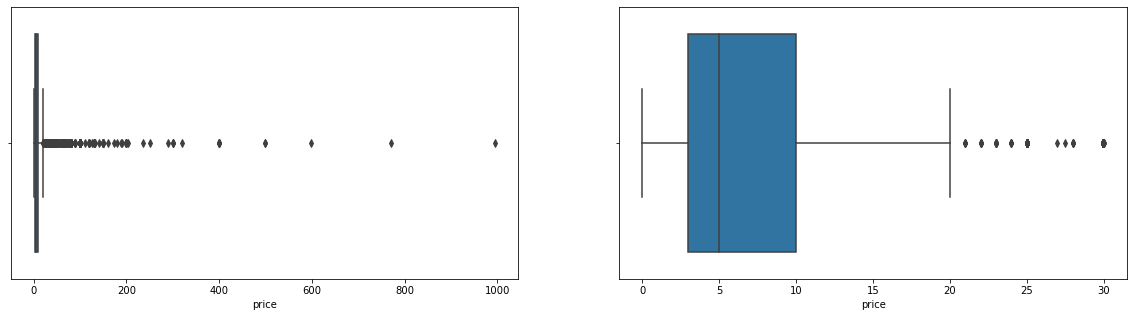

In [179]:
#Estudio de variable 'price'

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.boxplot(data=data_games,x='price') #Detecto rápidamente los outliers con el gráfico

plt.subplot(1,2,2)
filtro_horas=data_games[data_games.price<=30] #Utilizando este valor logro centralizar el rango de datos, tomando una muestra abarcativa de la población
sns.boxplot(data=filtro_horas,x='price') 

In [185]:
data_games=data_games[((data_games.price<=30))]
data_games.shape

(31203, 12)

In [186]:
data_games.to_csv('games.csv',index=False) #Exporto el dataset a un .csv para tener un dataset preprocesado y no tener que repetir código que tarde en correr.

## Modelo de Machine Learning

Utilizaré la librería Surprise (vista en clase) para poder implementar el sistema de recomendación basado en un filtro colaborativo a partir de la descomposición UV:

In [3]:
#carga de los datasets pre-armados que fui generando durante EDA
reviews = pd.read_csv('reviews.csv')
rev_base = pd.read_csv('reviews_base.csv')
games = pd.read_csv('games.csv')

In [4]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

In [5]:
rev_base.head()

,product_id,ranking,username_id
0,328100,3,0
1,725280,1,1
2,631920,2,2
3,671270,1,3
4,288690,1,4


Debo reorganizar las columnas del dataset para poder trabajar con esta librería:

In [6]:
#adapto la tabla al formato del "reader" de surprise
rev_base = rev_base.reindex(columns=['username_id','product_id','ranking'])
rev_base.head()

,username_id,product_id,ranking
0,0,328100,3
1,1,725280,1
2,2,631920,2
3,3,671270,1
4,4,288690,1


In [7]:
rev_base.shape

(68458, 3)

In [8]:
reader = Reader()
N_filas = 68458 # Limitamos el dataset a N_filas == shape de la tabla
data = Dataset.load_from_df(rev_base[['username_id','product_id','ranking']][:N_filas], reader)

In [9]:
trainset, testset = train_test_split(data, test_size=.25) #segmento el dataset en conjunto de entrenamiento y test

In [10]:
from surprise import SVD
algo = SVD()  #creo el modelo

In [11]:
algo.fit(trainset) #entreno el modelo

In [12]:
predictions = algo.test(testset) #predigo

In [13]:
from surprise import accuracy
accuracy.rmse(predictions)

RMSE: 0.7067


0.7066639945357643

Si bien el el RMSE es de 0.70, buscaré ajustar los hiperparámetros del modelo para lograr el mejor rendimiento posible. Primero utilizaré una validación cruzada para optimizar el número de factores del modelo, y luego ajustaré el resto de los hiperparámetros utilizando un Grid Search:

In [199]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Número de Factores: 1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.7055  0.7008  0.6943  0.7002  0.0046  
Fit time          0.71    0.71    0.74    0.72    0.01    
Test time         0.14    0.14    0.14    0.14    0.00    

Número de Factores: 2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.7002  0.7007  0.6978  0.6996  0.0012  
Fit time          1.04    0.93    0.73    0.90    0.13    
Test time         0.22    0.16    0.12    0.17    0.04    

Número de Factores: 4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.6991  0.6965  0.7041  0.6999  0.0032  
Fit time          0.83    0.84    0.87    0.85    0.02    
Test time         0.14    0.16    0.15    0.15    0.01    

Número de Factores: 8
Evaluating RMSE of algorithm SVD on 3 split(s).

    

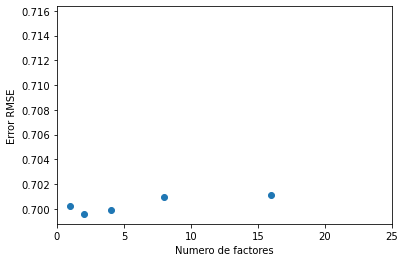

In [203]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.xlim([0, 25])
plt.show()

Mejor hiperparámetro--> Número de Factores: 2

In [14]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [2],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)

In [15]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.6998018944677574
{'n_factors': 2, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.002}


RMSE: 0.7067


Text(0, 0.5, 'Raíz del Error Cuadrático Medio')

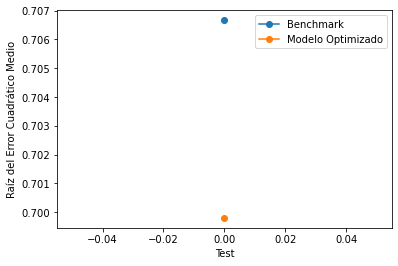

In [19]:
plt.plot([accuracy.rmse(predictions)],'o-',label='Benchmark' )
plt.plot([gs.best_score['rmse']],'o-',label='Modelo Optimizado')
plt.legend() #Habilito la leyenda
plt.xlabel("Test")
plt.ylabel("Raíz del Error Cuadrático Medio")

Podemos observar que si bien el modelo fue optimizado en cuanto a sus hiperparámetros, el rendimiento es bastante similar si tomamos como ejemplo sus parámetros por defecto

Como conclusión final, podemos determinar que el modelo no tiene una precisión demasiado alta, ya que dentro de los 3 valores posibles según cantidad de horas jugadas se estaría equivocando en un 0,7 lo que representaría casi un 25% de error al momento de la predicción. Pienso que probablemente este rendimiento se podría mejorar ya sea reduciendo aún más los outliers del dataset (evitando obviamente sesgar la muestra) o  incrementando los valores posibles de horas jugadas (por ejemplo a 5 o 10).

## Investigación

Me parecería interesante investigar la relación entre cantidad de juegos que tienen los usuarios y cuantos realmente fueron jugados. En mi caso personal poseo una gran cantidad de juegos en mi biblioteca de juegos, sin embargo siempre juego a los mismos 2. En base a este disparador podríamos quitarle peso a la variable de cantidad de juegos que tienen los usuarios y enfocar un análisis posterior determinando si los usuarios poseen muchos juegos que probablemente no juegan, en pos del refinamiento del sistema de recomendación.

Para poder realizar esto, la estrategia sería buscar las reviews con 0 horas de juego y agruparlas por usuario. Una vez obtenido el número de juegos  "no jugados" lo contrastaría con la cantidad de juegos de ese usuario para determinar que porcentaje de sus juegos "realmente" juega.

In [75]:
nojugados = pd.read_csv('reviews.csv')

In [76]:
nojugados= nojugados[nojugados.hours==0]
nojugados= nojugados.groupby(by="username_id").count()
nojugados.sort_values(by=['username'])

,username,hours,products,product_id,date,early_access,compensation,found_funny,ranking
username_id,,,,,,,,,
6520,1,1,1,1,1,1,1,1,1
7124,1,1,1,1,1,1,1,1,1
7158,1,1,1,1,1,1,1,1,1
7170,1,1,1,1,1,1,1,1,1
7238,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
6394,2,2,2,2,2,2,2,2,2
112,2,2,2,2,2,2,2,2,2
6833,2,2,2,2,2,2,2,2,2


Haciendo un análisis preliminar, podemos detectar que el usuario que menos juegos jugó fueron solamente 3. Si tomamos en cuenta que el promedio de juegos jugados por usuario son 237, este valor parecería poco representativo.